# Alpha Hyperparameter Tuning Analysis

This notebook analyzes perplexity and reading scores across different alpha values to find optimal hyperparameters for steering.

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
from pathlib import Path
import re
from pathlib import Path
# Import analysis functions
import sys
sys.path.append('/usr2/collab/kfuente1/SAE_gender')
from core.analysis import readability_score

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Load and Process Results

In [2]:

def extract_alpha_from_path(file_path):
    """Extract numeric alpha value (positive or negative) from file path."""
    match = re.search(r'alpha(-?\d+(?:\.\d+)?)', file_path)
    return float(match.group(1)) if match else None

def get_pretty_model_name(file_path: str) -> str:
    raw = Path(file_path).parts[-6] if len(Path(file_path).parts) >= 4 else "unknown"
    
    mapping = {
        "google_gemma-2-2b-it": "Gemma-2-2B-Instruct",
        "google_gemma-2-9b-it": "Gemma-2-9B-Instruct",
        "meta-llama_Llama-3.1-8B-Instruct": "Llama-3-8B-Instruct",
        "meta-llama-3-70b-instruct": "Llama-3-70B-Instruct",
        # add more as needed
    }
    
    return mapping.get(raw, raw.replace("_", " ").title())
def load_baseline_results(vector, base_dir="/project/buinlp/data/outputs/last_token_steer/alpha_tuning/"):
    pattern = f"{base_dir}/**/{vector}/**/*.pkl"
    """Load baseline experiment results from different alpha values."""
    results = []
    files = glob(pattern, recursive=True)
    
    print(f"Found {len(files)} result files")
    
    for file_path in files:
        try:
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
            
            # Extract metadata from path
            alpha = extract_alpha_from_path(file_path)
            model_name = get_pretty_model_name(file_path)
            occupation = Path(file_path).stem.split('_baseline')[0]
            
            for record in data:
                # Calculate reading scores for completions
                baseline_reading_scores = []
                steered_reading_scores = []
                
                for completion in record.get('completions', []):
                    baseline_text = completion.get('baseline', '')
                    steered_text = completion.get('steered', '')
                    
                    baseline_reading = readability_score(baseline_text)
                    steered_reading = readability_score(steered_text)
                    
                    if baseline_reading is not None:
                        baseline_reading_scores.append(baseline_reading)
                    if steered_reading is not None:
                        steered_reading_scores.append(steered_reading)
                
                results.append({
                    'file_path': file_path,
                    'model': model_name,
                    'occupation': occupation,
                    'alpha': alpha,
                    'question_id': record.get('question_id'),
                    'experiment': record.get('experiment'),
                    'steering_direction': record.get('steering_direction'),
                    'avg_baseline_perplexity': record.get('avg_baseline_perplexity'),
                    'avg_steered_perplexity': record.get('avg_steered_perplexity'),
                    'avg_baseline_reading': np.mean(baseline_reading_scores) if baseline_reading_scores else np.nan,
                    'avg_steered_reading': np.mean(steered_reading_scores) if steered_reading_scores else np.nan
                })
                
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue
    
    return pd.DataFrame(results)

# Load results    # Find all pickle files
    #pattern = f"{base_dir}/**/experience/**/*.pkl"
   # pattern = f"{base_dir}/**/expertise/**/*.pkl"
dfs = {}
dfs['expertise'] = load_baseline_results('expertise')
dfs['experience']  = load_baseline_results('experience')
# print(f"Loaded {len(df)} records")
# print(f"Models: {df['model'].unique()}")
# print(f"Alpha ranges: {df['alpha'].min():.1f} to {df['alpha'].max():.1f}")
# df.head()

Found 2001 result files
Found 1883 result files


In [3]:
def get_results(file_path):
    pattern = f"{file_path}/*.pkl"
    files = glob(pattern, recursive=True)
    results = []
    for file_path in files:
        try:
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
            for record in data:
                # Calculate reading scores for completions
                baseline_reading_scores = []
                steered_reading_scores = []
                
                for completion in record.get('completions', []):
                    baseline_text = completion.get('baseline', '')
                    steered_text = completion.get('steered', '')
                    
                    baseline_reading = readability_score(baseline_text)
                    steered_reading = readability_score(steered_text)
                    
                    if baseline_reading is not None:
                        baseline_reading_scores.append(baseline_reading)
                    if steered_reading is not None:
                        steered_reading_scores.append(steered_reading)
                    
                    results.append({
                        'file_path': file_path,
                        'occupation': 'developer',
                        'question_id': record.get('question_id'),
                        'experiment': record.get('experiment'),
                        'steer_text': steered_text,
                        'baseline_text': baseline_text,
                        'steering_direction': record.get('steering_direction'),
                        'avg_baseline_perplexity': record.get('avg_baseline_perplexity'),
                        'avg_steered_perplexity': record.get('avg_steered_perplexity'),
                        'avg_baseline_reading': np.mean(baseline_reading_scores) if baseline_reading_scores else np.nan,
                        'avg_steered_reading': np.mean(steered_reading_scores) if steered_reading_scores else np.nan
                    })
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue
    return results


In [9]:
alpha = 'alpha-5'
file_path = f"/project/buinlp/data/outputs/last_token_steer/alpha_tuning/baselines/developer/meta-llama_Llama-3.1-8B-Instruct/experience/{alpha}/temp0.6/topp0.8"
df_gemma = pd.DataFrame(get_results(file_path))
df_gemma.to_csv(f'meta-llama_Llama-3.1-8B-Instruct{alpha}_experience.csv')

In [25]:
file_path = "/project/buinlp/data/outputs/last_token_steer/alpha_tuning/baselines/developer/meta-llama_Llama-3.1-8B-Instruct/experience/alpha-10/temp0.6/topp0.8"
df_llama = pd.DataFrame(get_results(file_path))

In [26]:
df_llama.to_csv('llama_tuning_n10.csv')

In [107]:
#file_path = "/project/buinlp/data/outputs/last_token_steer/alpha_tuning/baselines/developer/google_gemma-2-2b-it/expertise/alpha5/temp0.6/topp0.8"
pattern = f"{file_path}/*.pkl"
files = glob(pattern, recursive=True)
results = []

for file_path in files:
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        for record in data:
            # Calculate reading scores for completions
            baseline_reading_scores = []
            steered_reading_scores = []
            
            for completion in record.get('completions', []):
                baseline_text = completion.get('baseline', '')
                steered_text = completion.get('steered', '')
                
                baseline_reading = readability_score(baseline_text)
                steered_reading = readability_score(steered_text)
                
                if baseline_reading is not None:
                    baseline_reading_scores.append(baseline_reading)
                if steered_reading is not None:
                    steered_reading_scores.append(steered_reading)
                
            results.append({
                'file_path': file_path,
                'occupation': 'developer',
                'question_id': record.get('question_id'),
                'experiment': record.get('experiment'),
                'steer_text': steered_text,
                'baseline_text': baseline_text,
                'steering_direction': record.get('steering_direction'),
                'avg_baseline_perplexity': record.get('avg_baseline_perplexity'),
                'avg_steered_perplexity': record.get('avg_steered_perplexity'),
                'avg_baseline_reading': np.mean(baseline_reading_scores) if baseline_reading_scores else np.nan,
                'avg_steered_reading': np.mean(steered_reading_scores) if steered_reading_scores else np.nan
            })
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        continue
df_v2 = pd.DataFrame(results)
df_v2.to_csv("pos5_df_last_token_alpha_steer_outputs.csv")

In [7]:
df = df[df['experiment'] == 'profession']

## Data Overview

In [92]:
# Check data completeness
print("Data completeness:")
print(f"Records with perplexity data: {df['avg_steered_perplexity'].notna().sum()}")
print(f"Records with reading score data: {df['avg_steered_reading'].notna().sum()}")
print(f"Unique alpha values: {sorted(df['alpha'].dropna().unique())}")
print(f"Occupations: {sorted(df['occupation'].unique())}")
print(f"Steering directions: {df['steering_direction'].value_counts()}")

Data completeness:
Records with perplexity data: 2305
Records with reading score data: 2305
Unique alpha values: [np.float64(-10.0), np.float64(-5.0), np.float64(-2.0), np.float64(0.0), np.float64(2.0), np.float64(5.0), np.float64(10.0)]
Occupations: ['accountant', 'construction_worker', 'cook', 'customer_service_rep', 'developer', 'housekeeper', 'janitor', 'laborer', 'manager', 'nurse', 'office_clerk']
Steering directions: steering_direction
negative    990
positive    990
none        325
Name: count, dtype: int64


## Perplexity Analysis Across Alpha Values

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# -------- Helpers --------
def build_alpha_summary(df_dir, alpha_col):
    df_dir = df_dir.dropna(subset=[alpha_col])
    grouped = df_dir.groupby([alpha_col, 'model']).agg({
        'avg_steered_perplexity': ['mean', 'std', 'count'],
        'avg_baseline_perplexity': ['mean', 'std'],
        'avg_steered_reading': ['mean', 'std'],
        'avg_baseline_reading': ['mean', 'std']
    }).reset_index()
    grouped.columns = ['_'.join(c).strip('_') for c in grouped.columns]
    grouped = grouped.rename(columns={alpha_col + '_': alpha_col})
    return grouped

def plot_direction(ax, alpha_summary, alpha_col, models, title,
                   model_palette=None,
                   linestyle_perplexity='-',
                   linestyle_reading='--',
                   marker='o'):
    """
    Models are colored; metrics are distinguished by line style.
    - Perplexity -> linestyle_perplexity on left y-axis
    - Reading    -> linestyle_reading on right y-axis
    """
    ax_left = ax                        # perplexity
    ax_right = ax.twinx()               # reading

    # Color per model
    if model_palette is None:
        model_palette = sns.color_palette("tab10", len(models))
    model_colors = {m: model_palette[i % len(model_palette)] for i, m in enumerate(models)}

    # Legends
    metric_handles = [
        Line2D([0], [0], color='black', lw=2, linestyle=linestyle_perplexity, label='Perplexity'),
        Line2D([0], [0], color='black', lw=2, linestyle=linestyle_reading,    label='Reading score'),
    ]
    model_handles = []

    for model in models:
        md = alpha_summary[alpha_summary['model'] == model].copy()
        if md.empty:
            continue
        c = model_colors[model]

        # ---- Perplexity ----
        mdp = md.dropna(subset=['avg_steered_perplexity_mean',
                                'avg_steered_perplexity_std',
                                'avg_baseline_perplexity_mean',
                                'avg_baseline_perplexity_std']).copy()
        if not mdp.empty:
            perp_df = pd.DataFrame({
                'alpha': [0] + mdp[alpha_col].tolist(),
                'mean':  [mdp['avg_baseline_perplexity_mean'].iloc[0]] + mdp['avg_steered_perplexity_mean'].tolist(),
                'std':   [mdp['avg_baseline_perplexity_std'].iloc[0]]  + mdp['avg_steered_perplexity_std'].tolist(),
            }).sort_values('alpha')

            ax_left.errorbar(
                perp_df['alpha'], perp_df['mean'], yerr=perp_df['std'],
                marker=marker, linestyle=linestyle_perplexity, linewidth=2,
                color=c, alpha=0.95, capsize=3, markersize=5
            )

        # ---- Reading ----
        mdr = md.dropna(subset=['avg_steered_reading_mean',
                                'avg_steered_reading_std',
                                'avg_baseline_reading_mean',
                                'avg_baseline_reading_std']).copy()
        if not mdr.empty:
            read_df = pd.DataFrame({
                'alpha': [0] + mdr[alpha_col].tolist(),
                'mean':  [mdr['avg_baseline_reading_mean'].iloc[0]] + mdr['avg_steered_reading_mean'].tolist(),
                'std':   [mdr['avg_baseline_reading_std'].iloc[0]]  + mdr['avg_steered_reading_std'].tolist(),
            }).sort_values('alpha')

            ax_right.errorbar(
                read_df['alpha'], read_df['mean'], yerr=read_df['std'],
                marker=marker, linestyle=linestyle_reading, linewidth=2,
                color=c, alpha=0.95, capsize=3, markersize=5
            )

        # Model legend: color encodes model (plain line)
        model_handles.append(
            Line2D([0], [0], color=c, lw=2, label=model)
        )

    ax_left.set_title(title)
    ax_left.set_xlabel('Alpha')
    ax_left.set_ylabel('Average Perplexity')
    ax_right.set_ylabel('Average Reading Score')
    ax_left.grid(True, alpha=0.3)

    leg1 = ax_left.legend(handles=metric_handles, loc='upper left', frameon=False, title='Metrics')
    leg2 = ax_right.legend(handles=model_handles, loc='upper right', frameon=False, title='Models')
    ax_left.add_artist(leg1)




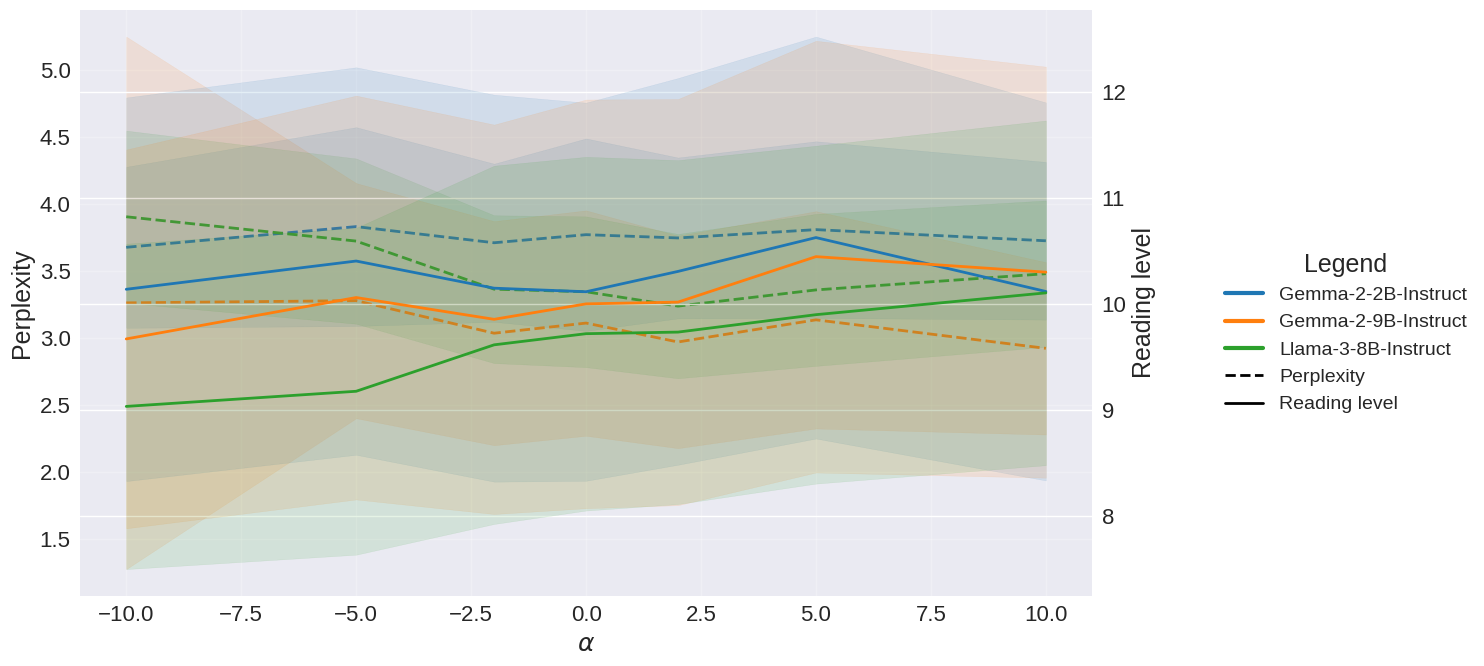

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams.update({
    "font.size": 18,          # default font size
    "axes.titlesize": 20,     # title
    "axes.labelsize": 18,     # x and y labels
    "xtick.labelsize": 16,    # x tick labels
    "ytick.labelsize": 16,    # y tick labels
    "legend.fontsize": 14,    # legend
})

def _prepare_alpha_summary_nodir(df: pd.DataFrame) -> pd.DataFrame:
    """
    Summarize by (model, alpha) only. Inject α=0 using baselines.
    Works whether df mixes positive/negative directions or not.
    """
    df = df.copy()
    need = {
        'model','alpha',
        'avg_baseline_perplexity','avg_steered_perplexity',
        'avg_baseline_reading','avg_steered_reading'
    }
    assert need.issubset(df.columns)

    # 1) Aggregate steered metrics by (model, alpha)
    steered = (
        df.groupby(['model','alpha'], as_index=False)
          .agg(
              steered_perp_mean=('avg_steered_perplexity','mean'),
              steered_perp_std =('avg_steered_perplexity','std'),
              steered_read_mean=('avg_steered_reading','mean'),
              steered_read_std =('avg_steered_reading','std'),
              n=('avg_steered_perplexity','size')
          )
    )

    # 2) Aggregate baseline once per model, inject as α=0
    base = (
        df.groupby(['model'], as_index=False)
          .agg(
              base_perp_mean=('avg_baseline_perplexity','mean'),
              base_perp_std =('avg_baseline_perplexity','std'),
              base_read_mean=('avg_baseline_reading','mean'),
              base_read_std =('avg_baseline_reading','std'),
              n=('avg_baseline_perplexity','size')
          )
    )
    base['alpha'] = 0.0
    base.rename(columns={
        'base_perp_mean':'steered_perp_mean',
        'base_perp_std':'steered_perp_std',
        'base_read_mean':'steered_read_mean',
        'base_read_std':'steered_read_std'
    }, inplace=True)

    # If α=0 exists already, overwrite with baseline; else append it
    has_zero = (steered['alpha'] == 0).any()
    if has_zero:
        steered = steered.merge(
            base[['model','alpha','steered_perp_mean','steered_perp_std',
                  'steered_read_mean','steered_read_std']],
            on=['model','alpha'],
            how='left',
            suffixes=('','_base')
        )
        for col in ['steered_perp_mean','steered_perp_std','steered_read_mean','steered_read_std']:
            steered[col] = np.where(
                steered[f'{col}_base'].notna(),
                steered[f'{col}_base'],
                steered[col]
            )
        steered.drop(columns=[c for c in steered.columns if c.endswith('_base')], inplace=True)
    else:
        base = base[['model','alpha','steered_perp_mean','steered_perp_std',
                     'steered_read_mean','steered_read_std','n']]
        steered = pd.concat([steered, base], ignore_index=True)

    return steered.sort_values(['model','alpha']).reset_index(drop=True)


def plot_alpha_tuning_combined_dual_y(
    df: pd.DataFrame,
    savepath='/usr2/collab/kfuente1/SAE_gender/figures/alpha_tuning.pdf'
):
    """
    One figure, dual y-axes:
      - Left y: Perplexity (dashed)
      - Right y: Reading level (solid)
    Color = model. No style difference for positive vs negative directions.
    Legend lives outside the plot.
    """
    summary = _prepare_alpha_summary_nodir(df)

    models = sorted(summary['model'].unique())
    palette = dict(zip(models, sns.color_palette('tab10', len(models))))

    fig, ax_left = plt.subplots(figsize=(12, 7))
    ax_right = ax_left.twinx()

    model_handles = {}
    metric_handles = {}

    for model in models:
        md = summary[summary['model'] == model]
        if md.empty:
            continue

        # Perplexity (left, dashed)
        ln_perp, = ax_left.plot(
            md['alpha'], md['steered_perp_mean'],
            linestyle='--', linewidth=2, color=palette[model],
            label=f'{model} – Perplexity'
        )
        ax_left.fill_between(
            md['alpha'],
            md['steered_perp_mean'] - md['steered_perp_std'],
            md['steered_perp_mean'] + md['steered_perp_std'],
            alpha=0.12, color=palette[model]
        )

        # Reading (right, solid)
        ln_read, = ax_right.plot(
            md['alpha'], md['steered_read_mean'],
            linestyle='-', linewidth=2, color=palette[model],
            label=f'{model} – Reading'
        )
        ax_right.fill_between(
            md['alpha'],
            md['steered_read_mean'] - md['steered_read_std'],
            md['steered_read_mean'] + md['steered_read_std'],
            alpha=0.12, color=palette[model]
        )

        if model not in model_handles:
            model_handles[model] = Line2D([0],[0], color=palette[model], lw=3, label=model)

    # Metric legend keys (black, generic lines)
    if 'Perplexity' not in metric_handles:
        metric_handles['Perplexity'] = Line2D([0],[0], lw=2, linestyle='--', color='black', label='Perplexity')
    if 'Reading level' not in metric_handles:
        metric_handles['Reading level'] = Line2D([0],[0], lw=2, linestyle='-', color='black', label='Reading level')

    ax_left.set_xlabel(r"$\alpha$")
    ax_left.set_ylabel('Perplexity')
    ax_right.set_ylabel('Reading level')
    #ax_left.set_title('Perplexity vs Reading Level')

    ax_left.grid(True, alpha=0.25)
    fig.tight_layout()

    # Clean, outside legend: first models (colors), then metric styles
    legend_items = list(model_handles.values()) + list(metric_handles.values())
    fig.legend(
        handles=legend_items,
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        frameon=False,
        title='Legend'
    )

    plt.savefig(savepath, bbox_inches='tight')
    plt.show()


# ---- Usage ----
df = dfs['expertise']
plot_alpha_tuning_combined_dual_y(df)


In [7]:
df.columns

Index(['file_path', 'model', 'occupation', 'alpha', 'question_id',
       'experiment', 'steering_direction', 'avg_baseline_perplexity',
       'avg_steered_perplexity', 'avg_baseline_reading',
       'avg_steered_reading'],
      dtype='object')

## Expertise 

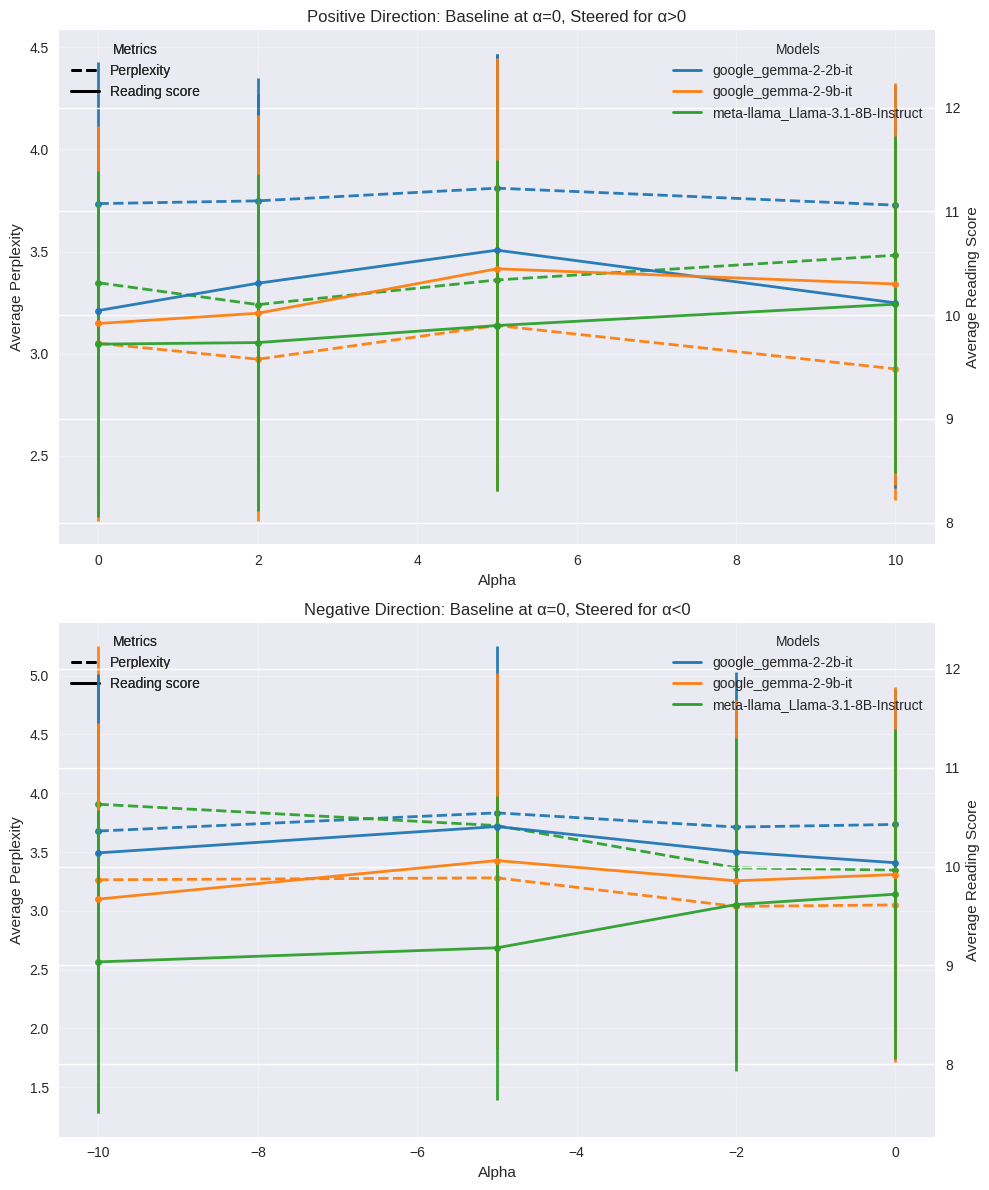

NameError: name 'g' is not defined

In [7]:
# -------- Plot example --------
df = dfs['expertise']
def plot_alpha_tuning(df, savepath='/usr2/collab/kfuente1/SAE_gender/figures'): 
    df_pos = df[df['steering_direction'] == 'positive'].copy()
    alpha_pos_col = 'alpha'
    alpha_summary_pos = build_alpha_summary(df_pos, alpha_pos_col)
    
    df_neg = df[df['steering_direction'] == 'negative'].copy()
    alpha_neg_col = 'alpha'
    if alpha_neg_col not in df_neg.columns and alpha_pos_col in df_neg.columns:
        df_neg[alpha_neg_col] = df_neg[alpha_pos_col]
    alpha_summary_neg = build_alpha_summary(df_neg, alpha_neg_col)
    
    models = sorted(set(alpha_summary_pos['model']).union(set(alpha_summary_neg['model'])))
    palette = sns.color_palette("tab10", len(models))
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=False)
    
    plot_direction(
        axes[0], alpha_summary_pos, alpha_pos_col, models,
        title='Positive Direction: Baseline at α=0, Steered for α>0',
        model_palette=palette,
        linestyle_perplexity='--', linestyle_reading='-'
    )
    
    plot_direction(
        axes[1], alpha_summary_neg, alpha_neg_col, models,
        title='Negative Direction: Baseline at α=0, Steered for α<0',
        model_palette=palette,
        linestyle_perplexity='--', linestyle_reading='-'
    )
    
    plt.tight_layout()
    plt.show()
    g.savefig(savepath, dpi=300, bbox_inches="tight")

plot_alpha_tuning(df)

## Experience

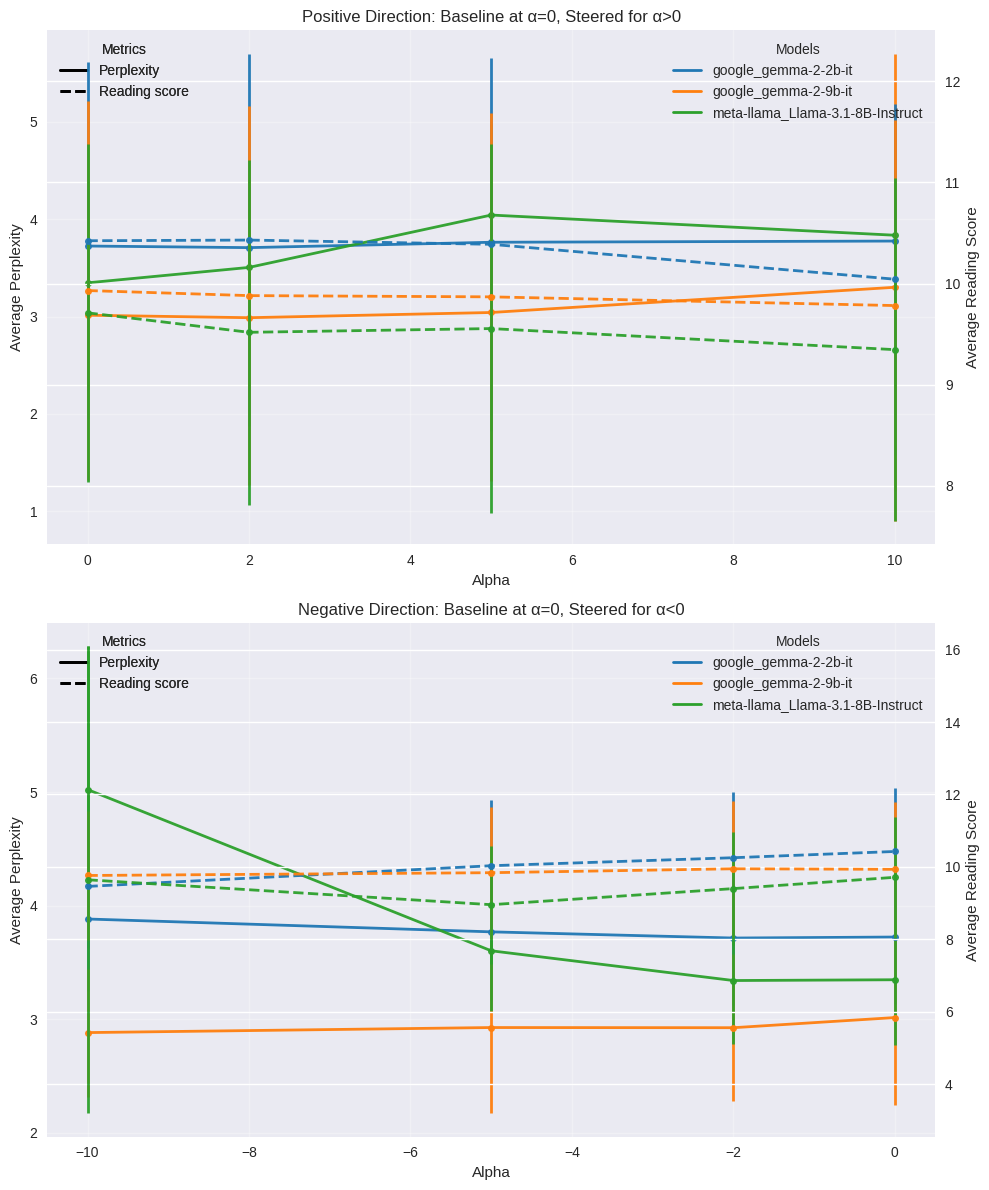

In [6]:
# -------- Plot example --------
df = dfs['experience']
df_pos = df[df['steering_direction'] == 'positive'].copy()
alpha_pos_col = 'alpha'
alpha_summary_pos = build_alpha_summary(df_pos, alpha_pos_col)

df_neg = df[df['steering_direction'] == 'negative'].copy()
alpha_neg_col = 'alpha'
if alpha_neg_col not in df_neg.columns and alpha_pos_col in df_neg.columns:
    df_neg[alpha_neg_col] = df_neg[alpha_pos_col]
alpha_summary_neg = build_alpha_summary(df_neg, alpha_neg_col)

models = sorted(set(alpha_summary_pos['model']).union(set(alpha_summary_neg['model'])))
palette = sns.color_palette("tab10", len(models))

fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=False)

plot_direction(
    axes[0], alpha_summary_pos, alpha_pos_col, models,
    title='Positive Direction: Baseline at α=0, Steered for α>0',
    model_palette=palette,
    linestyle_perplexity='-', linestyle_reading='--'
)

plot_direction(
    axes[1], alpha_summary_neg, alpha_neg_col, models,
    title='Negative Direction: Baseline at α=0, Steered for α<0',
    model_palette=palette,
    linestyle_perplexity='-', linestyle_reading='--'
)

plt.tight_layout()
plt.show()


## Combined Objective Analysis

/scratch/410370.1.csgpu/ipykernel_2446378/1670957578.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/scratch/410370.1.csgpu/ipykernel_2446378/1670957578.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/scratch/410370.1.csgpu/ipykernel_2446378/1670957578.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/scratch/410370.1.csgpu/ipykernel_2446378/1670957578.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), r

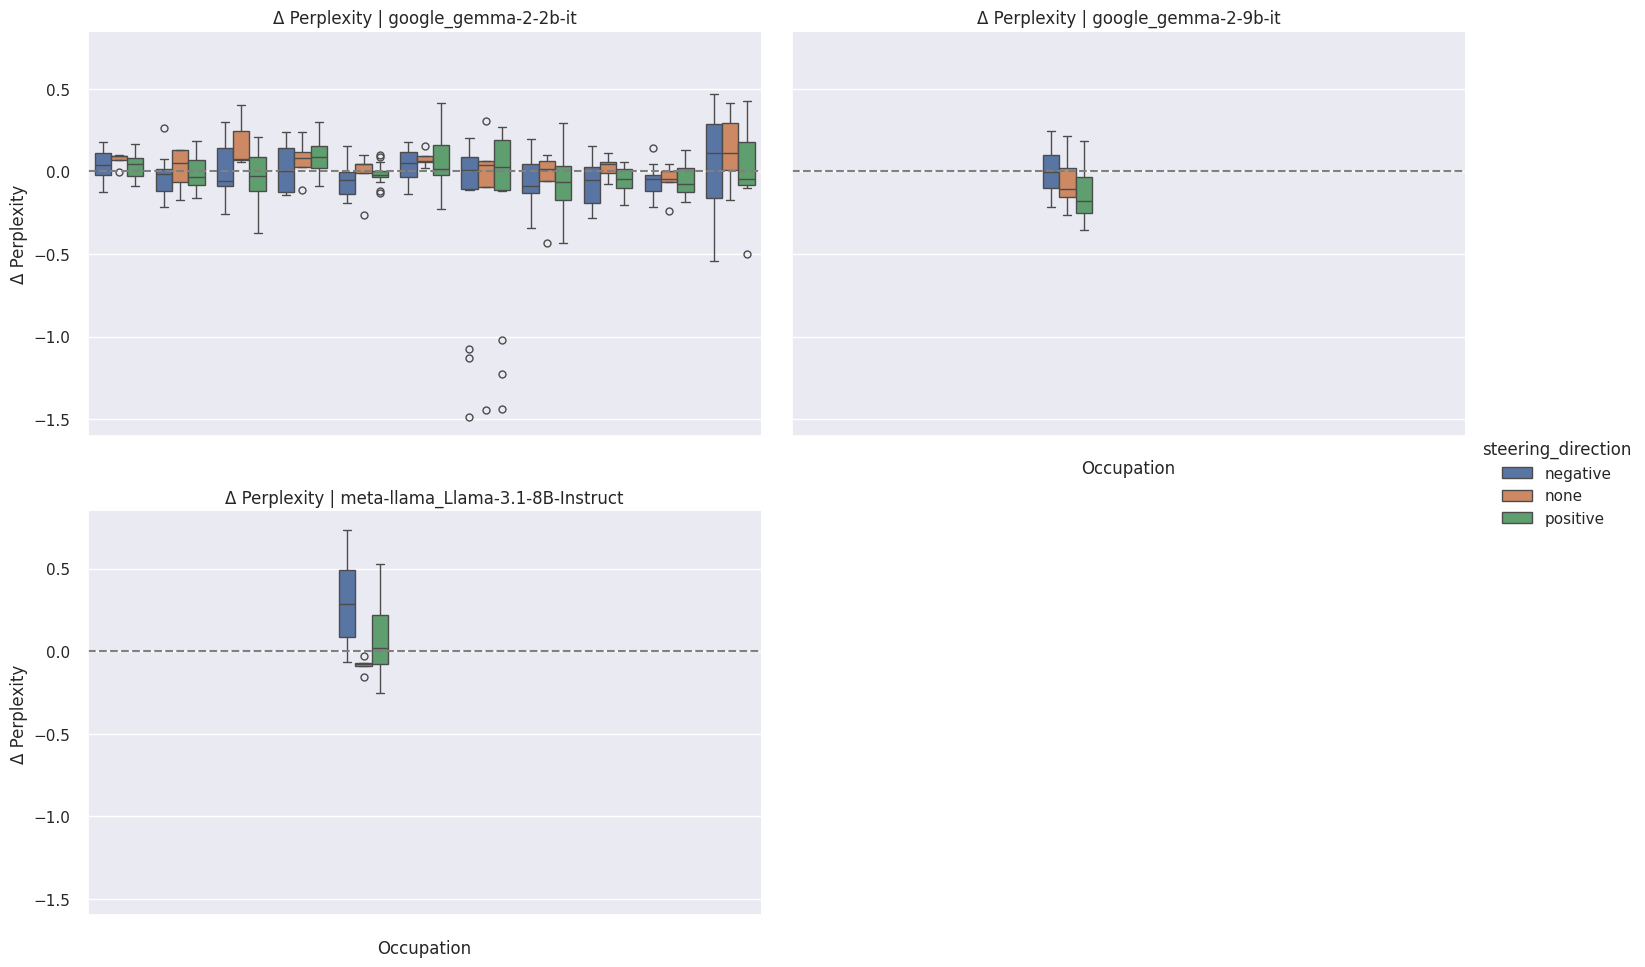

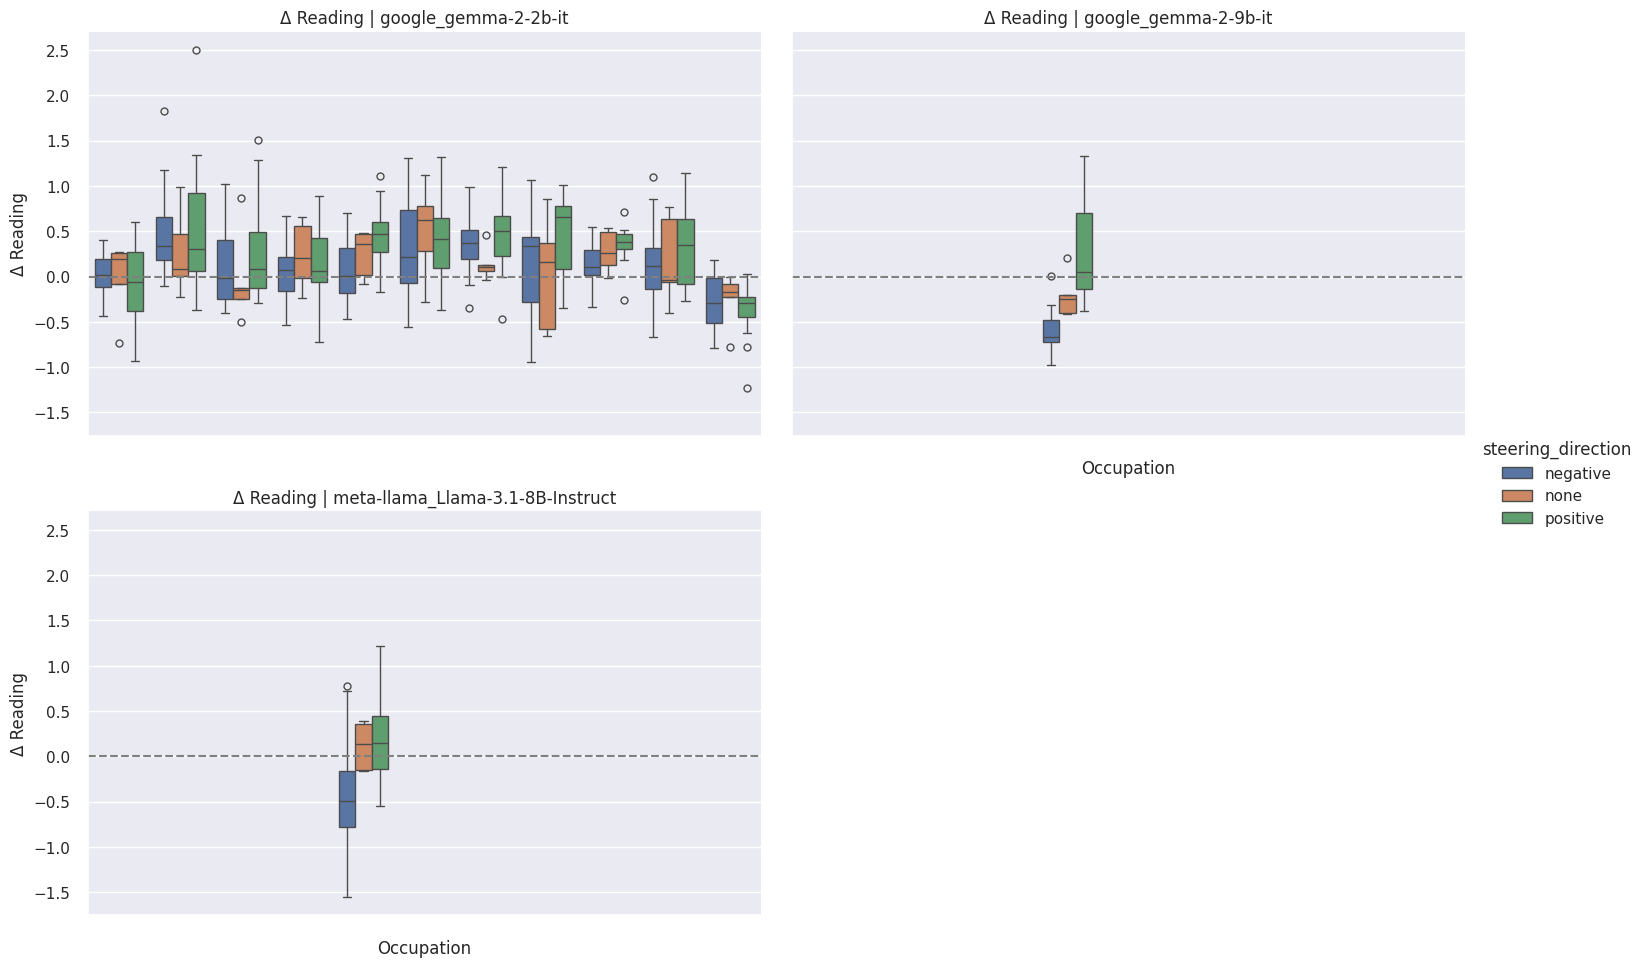

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: compute deltas ---
df["delta_perplexity"] = df["avg_steered_perplexity"] - df["avg_baseline_perplexity"]
df["delta_reading"] = df["avg_steered_reading"] - df["avg_baseline_reading"]

# --- Step 2: average across responses for the same question ---
question_avg = (
    df.groupby(
        ["model", "occupation", "alpha", "question_id", "steering_direction", "experiment"],
        as_index=False
    )[["delta_perplexity", "delta_reading"]].mean()
)

# --- Step 3: boxplots by occupation and model ---

# Perplexity delta faceted by model
g1 = sns.catplot(
    data=question_avg,
    x="occupation",
    y="delta_perplexity",
    hue="steering_direction",
    col="model",
    kind="box",
    col_wrap=2,   # adjust depending on #models
    height=5,
    aspect=1.5
)
for ax in g1.axes.flat:
    ax.axhline(0, color="grey", linestyle="--")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
g1.set_titles("Δ Perplexity | {col_name}")
g1.set_axis_labels("Occupation", "Δ Perplexity")

# Reading delta faceted by model
g2 = sns.catplot(
    data=question_avg,
    x="occupation",
    y="delta_reading",
    hue="steering_direction",
    col="model",
    kind="box",
    col_wrap=2,
    height=5,
    aspect=1.5
)
for ax in g2.axes.flat:
    ax.axhline(0, color="grey", linestyle="--")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
g2.set_titles("Δ Reading | {col_name}")
g2.set_axis_labels("Occupation", "Δ Reading")

plt.show()


## Expertise

/scratch/474944.1.csgpu/ipykernel_2825758/3711690215.py:20: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.catplot(
/scratch/474944.1.csgpu/ipykernel_2825758/3711690215.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/scratch/474944.1.csgpu/ipykernel_2825758/3711690215.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


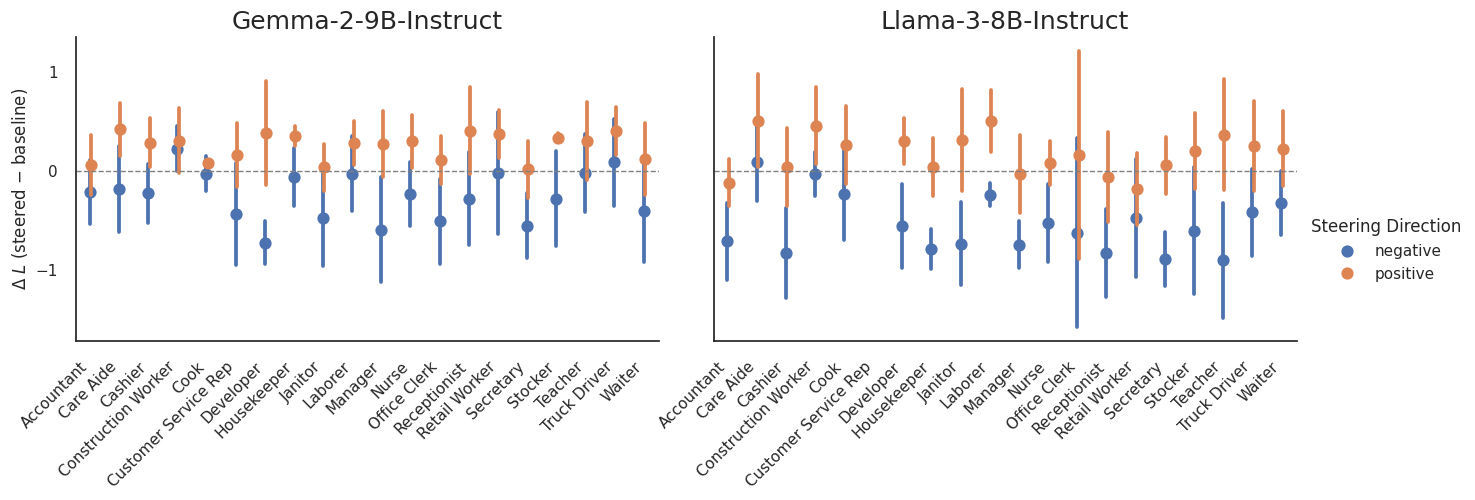

In [6]:
# --- 1) Change in reading score ---


def plot_mean_std(sub_df, savepath='/usr2/collab/kfuente1/SAE_gender/figures/steering_pos_neg_by_occ.pdf'): 
    def prettify_label(label: str) -> str:
    # replace underscores with spaces and capitalize each word
        return label.replace("_", " ").title()
    sub_df["delta_reading"] = sub_df["avg_steered_reading"] - sub_df["avg_baseline_reading"]
    
    # --- 2) Average across responses for the same question ---
    question_avg = (
        sub_df.groupby(
            ["model", "occupation", "alpha", "question_id", "steering_direction", "experiment"],
            as_index=False
        )["delta_reading"].mean()
    )
    
    # --- 3) Faceted point plots by model (mean ± std), horizontally separated ---
    sns.set_theme(style='white')
    g = sns.catplot(
        data=question_avg,
        x="occupation",
        y="delta_reading",
        hue="steering_direction",
        col="model",            # separate subplot per model
        kind="point",
        estimator="mean",
        errorbar=("sd"),        # show ± std
        dodge=True,
        join=False,
        height=4.2,
        aspect=1.6,
        col_wrap=None           # all models in one row if space allows; set an int (e.g., 3) to wrap
    )
    
    # cosmetics
    for ax in g.axes.flat:
        ax.axhline(0, linestyle="--", linewidth=1, color="grey")
        ax.set_xticklabels(
        [prettify_label(label.get_text()) for label in ax.get_xticklabels()],
        rotation=45, ha="right"
    )
    plt.rcParams.update({
        "font.size": 18,
        "axes.titlesize": 20,
        "axes.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 14,
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.edgecolor": "lightgrey",
    })
    
    # --- Move legend outside ---
    if g._legend is not None:
        g._legend.set_title("Steering Direction")
        # g._legend.set_bbox_to_anchor((.99, 0.5))   # right side, centered vertically
        # g._legend.set_frame_on(False)
    g.set_axis_labels("", r"$\Delta$ $L$ (steered − baseline)")
    g.set_titles("{col_name}")
    plt.savefig(savepath, dpi=300, bbox_inches='tight',bbox_extra_artists=(g._legend,) if g._legend is not None else None,
        pad_inches=0.2,)
    plt.show()

    
def filter_by_alpha_config(df, cfg, tol=1e-9):
    """
    Keep rows whose (model, alpha, steering_direction) matches the config.
    - cfg[model]['positive'] are matched when alpha > 0
    - cfg[model]['negative'] are matched when alpha < 0
    Uses np.isclose for float-safe matching.
    """
    df = df.copy()
    keep_mask = np.zeros(len(df), dtype=bool)

    for model, sides in cfg.items():
        m_mask = (df["model"] == model)

        if "positive" in sides and sides["positive"]:
            pos_targets = np.array(sides["positive"], dtype=float)
            # alpha in pos_targets (float-safe) AND either direction OR ignore direction
            pos_mask = m_mask & (df["alpha"] > 0) & np.any(
                np.isclose(df["alpha"].to_numpy()[:, None], pos_targets[None, :], atol=tol), axis=1
            )
            keep_mask |= pos_mask

        if "negative" in sides and sides["negative"]:
            neg_targets = np.array(sides["negative"], dtype=float)
            neg_mask = m_mask & (df["alpha"] < 0) & np.any(
                np.isclose(df["alpha"].to_numpy()[:, None], neg_targets[None, :], atol=tol), axis=1
            )
            keep_mask |= neg_mask

    return df[keep_mask]
ALPHA_CFG = {
    "Gemma-2-2B-Instruct": {"positive": [5], "negative": [-5]},
    "Gemma-2-9B-Instruct": {"positive": [5], "negative": [-10]},
    "Llama-3-8B-Instruct": {"positive": [5], "negative": [-5]},
    # Add more models as needed
}

df = dfs['expertise']
df = df[df["model"] != "Gemma-2-2B-Instruct"]

sub_df = filter_by_alpha_config(df, ALPHA_CFG)   # select per-model α’s
plot_mean_std(sub_df)


In [ ]:
df

## Experience

/scratch/410370.1.csgpu/ipykernel_2446378/2812257758.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["delta_reading"] = sub_df["avg_steered_reading"] - sub_df["avg_baseline_reading"]
/scratch/410370.1.csgpu/ipykernel_2446378/2812257758.py:15: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.catplot(
/scratch/410370.1.csgpu/ipykernel_2446378/2812257758.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/scratch/410370.1.csgpu/ipykernel_2446378/2812257758.py:34: UserWarning: set_tic

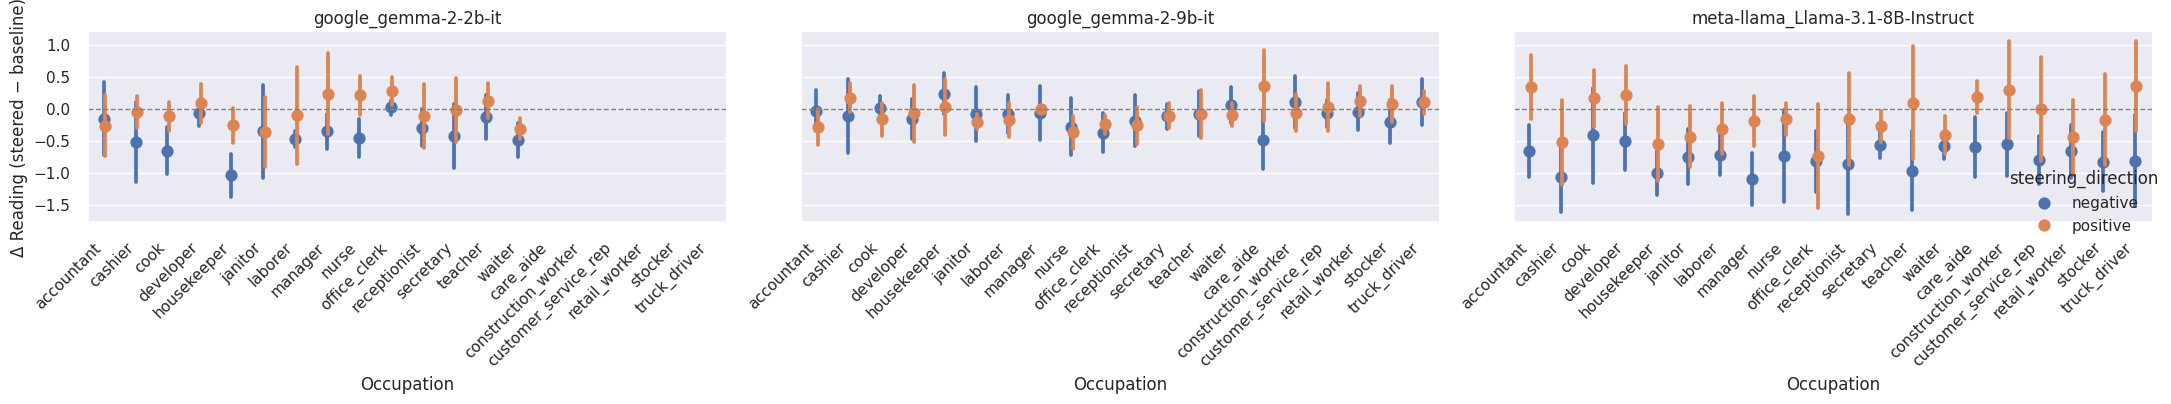

In [116]:
df = dfs['experience']
plot_mean_std(sub_df = df[(df['alpha'] == 5) | (df['alpha'] == -5) ])